# spass数据分析预操作

## 预设

In [3]:
import sys
import os
import openpyxl
import csv
import re
import pandas as pd
import jieba
import jieba.posseg as psg
import jieba.analyse as analyse
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cn2an
import functools

In [4]:
# 支持中文
print(matplotlib.matplotlib_fname())
a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for i in a:
    if 'Song' in i:
        print(i)
plt.rcParams['font.sans-serif'] = ['Songti SC'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
# 显示清晰
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/zackyule/.pyenv/versions/3.11.0/envs/NLP_basic/lib/python3.11/site-packages/matplotlib/mpl-data/matplotlibrc
Songti SC


In [6]:
ExtraDictionaryPath = 'set/dict.txt'
StopWordPath = 'set/stopwords.txt'
KeywordTopNumber = 10
minLengthOfWord = 3
DataFilePath = '../data/西安城市形象数据_关键词_议题分类.pkl'
IDFFilePath = 'set/idf.txt'
KeywordFilePath = '../data/西安项目编码统计结果1.pkl'

## 操作

In [7]:
data = pd.read_pickle(DataFilePath)
# keyword_data = pd.read_pickle(KeywordFilePath)

### 平台对比分析

In [8]:
data[data['平台'] == '豆瓣'].shape

(1170, 42)

In [13]:
data = data[['点赞数', '平台']]
weibo = data[data['平台'] == '微博'].sample(1170)
zhihu = data[data['平台'] == '知乎'].sample(1170)
douban = data[data['平台'] == '豆瓣']
data = pd.concat([zhihu, weibo, douban])

In [14]:
bins=[0,2,5,10,20,30,40,50,60,70,80,90,100,120,150,200,500,1000,5000,10000,100000]
segments=pd.cut(data['点赞数'],bins,right=False)
seg_weibo = pd.cut(weibo['点赞数'],bins,right=False)
seg_zhihu = pd.cut(zhihu['点赞数'],bins,right=False)
seg_douban = pd.cut(douban['点赞数'],bins,right=False)

In [15]:
counts=pd.value_counts(segments,sort=False)
counts_weibo=pd.value_counts(seg_weibo,sort=False)
counts_zhihu=pd.value_counts(seg_zhihu,sort=False)
counts_douban=pd.value_counts(seg_douban,sort=False)

### 微博爬取数量统计

In [12]:
weibo = data[data['平台'] == '微博']

### 对应分析

In [178]:
def get_tag_from_frame(df, column_names):
    for name in column_names:
        df[name].replace(1,name,inplace=True)
        df[name].replace(0,'非'+name,inplace=True)
    return df

In [180]:
column_names = keyword_data['二级框架类型']

In [181]:
data = data[column_names]
data = get_tag_from_frame(data, column_names)

In [184]:
data = data.sample(40000)

## 数据展示

In [182]:
data

,政治环境,经济发展,生态建设,文化风俗,重大事件,司法治安,医疗卫生,基础设施,科教文艺,休闲娱乐,社会民生,市民样貌,积极判断框架,消极判断框架,事件框架,细节框架
0,非政治环境,非经济发展,非生态建设,文化风俗,重大事件,非司法治安,非医疗卫生,基础设施,非科教文艺,休闲娱乐,社会民生,非市民样貌,非积极判断框架,非消极判断框架,事件框架,细节框架
1,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,休闲娱乐,社会民生,非市民样貌,非积极判断框架,非消极判断框架,非事件框架,细节框架
2,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,非休闲娱乐,社会民生,市民样貌,非积极判断框架,非消极判断框架,非事件框架,细节框架
3,非政治环境,非经济发展,非生态建设,文化风俗,非重大事件,非司法治安,非医疗卫生,基础设施,非科教文艺,非休闲娱乐,社会民生,非市民样貌,非积极判断框架,非消极判断框架,事件框架,细节框架
4,非政治环境,非经济发展,非生态建设,文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,休闲娱乐,社会民生,非市民样貌,非积极判断框架,非消极判断框架,事件框架,细节框架
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71046,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,非休闲娱乐,非社会民生,非市民样貌,非积极判断框架,非消极判断框架,非事件框架,非细节框架
71047,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,非休闲娱乐,非社会民生,非市民样貌,非积极判断框架,非消极判断框架,非事件框架,非细节框架
71048,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,非休闲娱乐,非社会民生,非市民样貌,非积极判断框架,非消极判断框架,非事件框架,非细节框架
71049,非政治环境,非经济发展,非生态建设,非文化风俗,非重大事件,非司法治安,非医疗卫生,非基础设施,非科教文艺,非休闲娱乐,非社会民生,非市民样貌,非积极判断框架,非消极判断框架,非事件框架,非细节框架


## 数据保存

In [185]:
data.to_csv('data/0框架对应分析.csv')

## 可视化

In [16]:
def auto_label(rect_group, ax):
    """Attach a text label above each bar in *rect_group*, displaying its height."""
    for rect in rect_group:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')

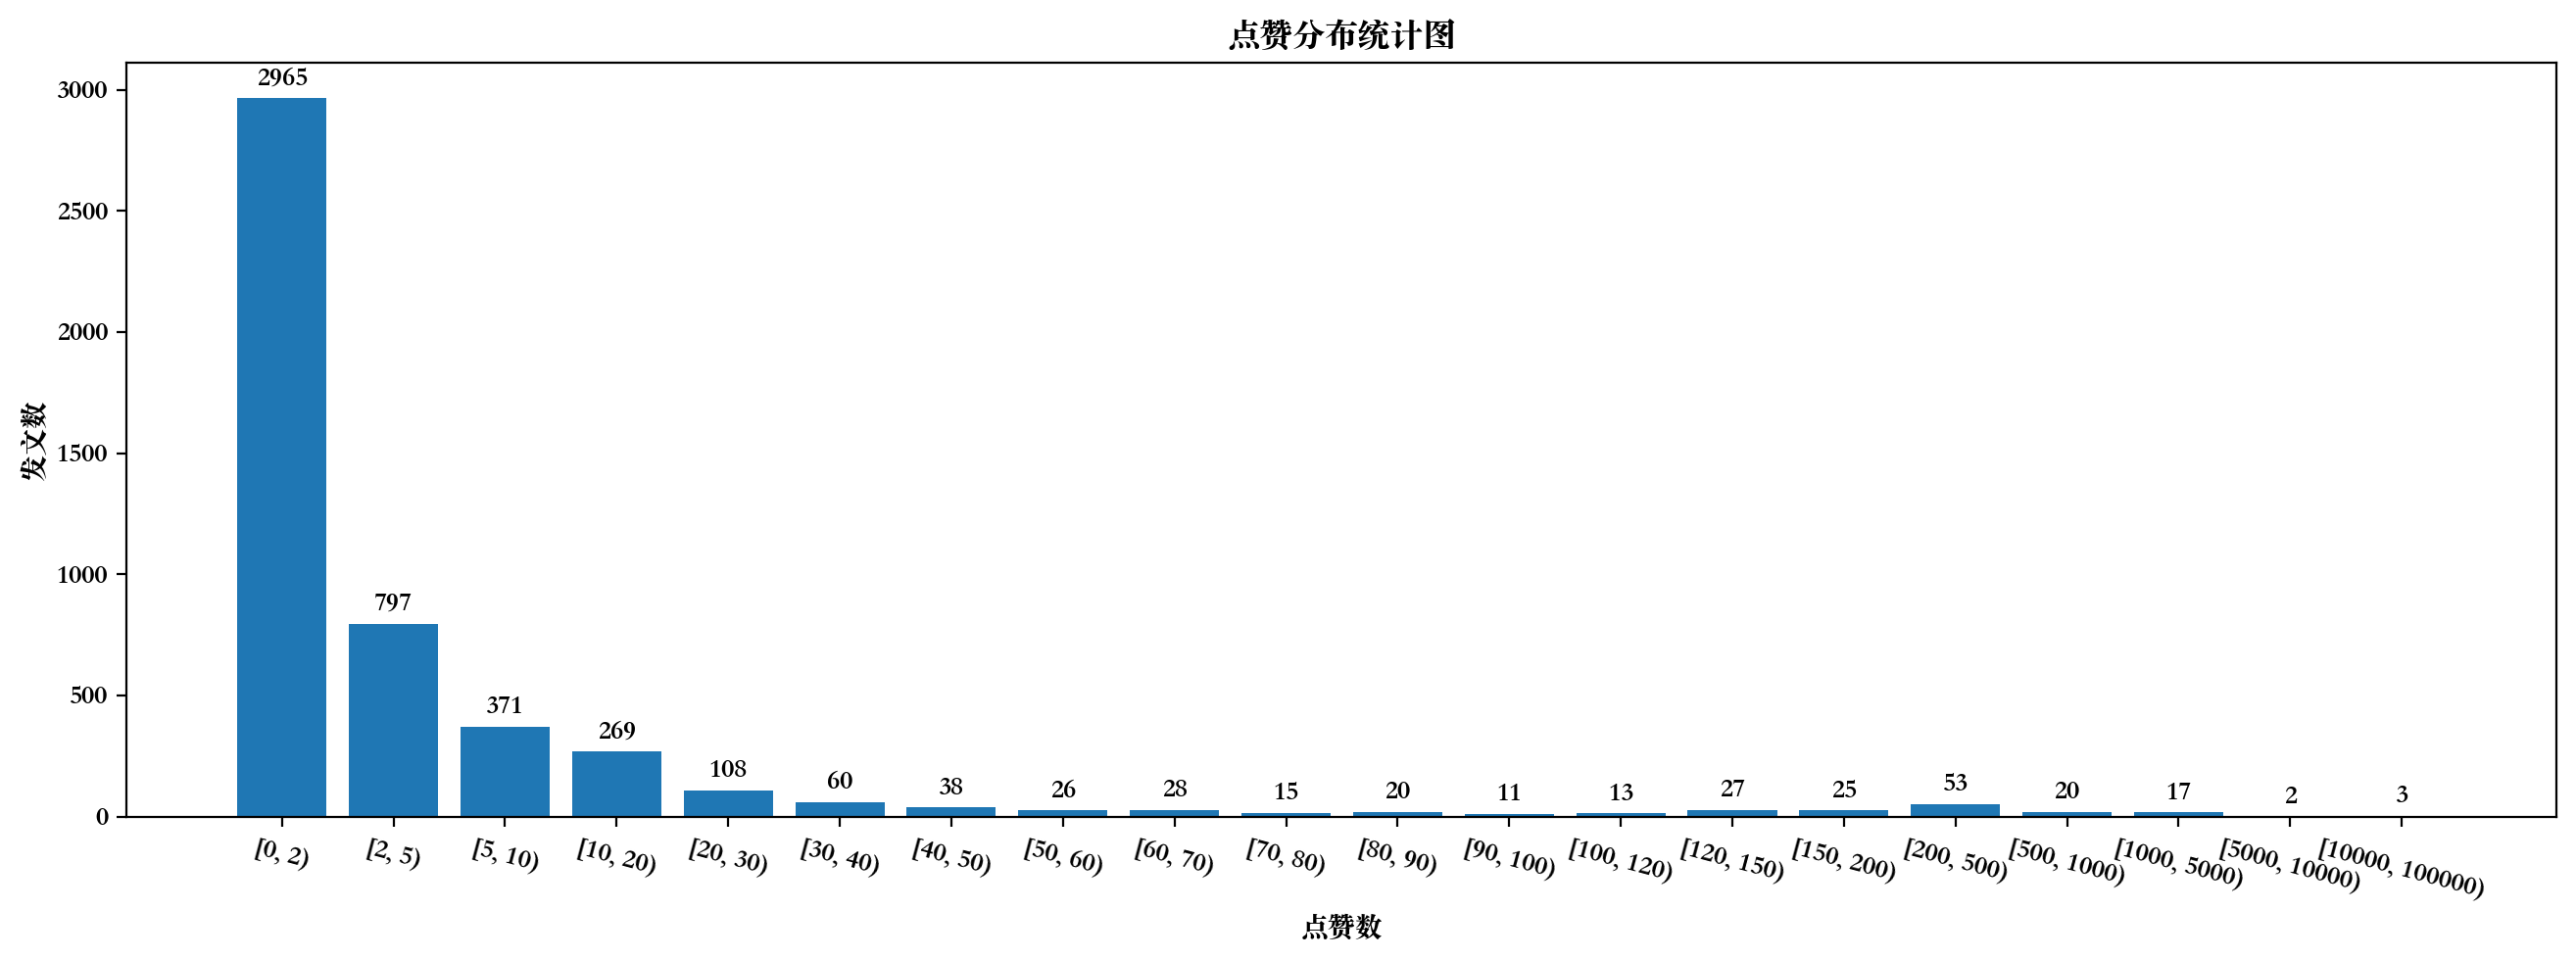

In [13]:
fig, ax = plt.subplots(figsize=(16, 5))
total_bar = ax.bar(counts.index.astype(str),counts)
ax.set_xlabel('点赞数')
ax.set_ylabel('发文数')
ax.set_title('点赞分布统计图')
autolabel(total_bar)
plt.xticks(rotation=-15)    # 设置x轴标签旋转角度
plt.show()

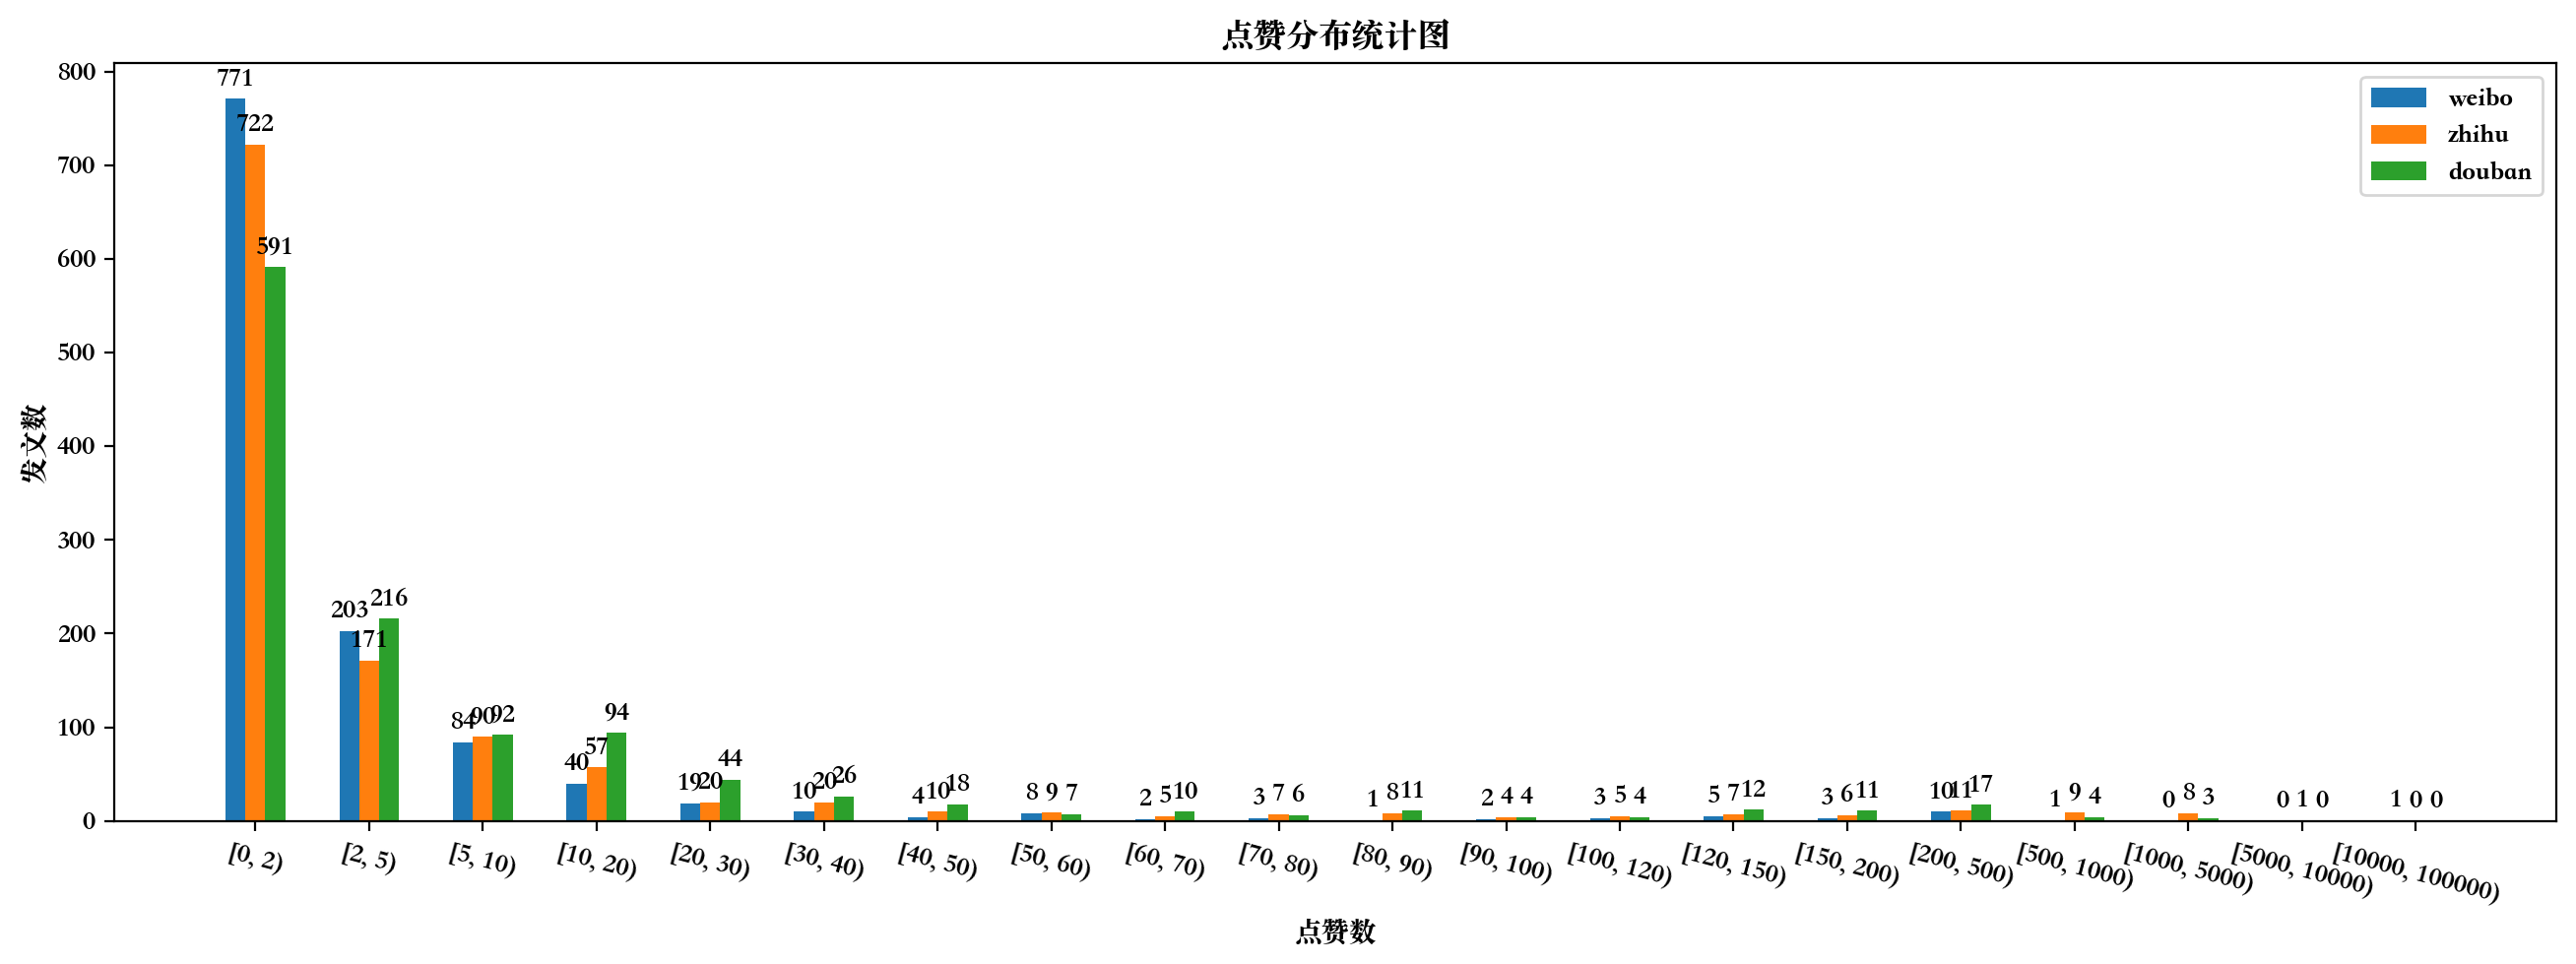

In [17]:
fig, ax = plt.subplots(figsize=(16, 5))
x = np.arange(len(counts.index))
width = 0.35
weibo_bar = ax.bar(x - width/2, counts_weibo, width/2, label='weibo')
zhihu_bar = ax.bar(x, counts_zhihu, width/2, label='zhihu')
douban_bar = ax.bar(x + width/2, counts_douban, width/2, label='douban')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(counts.index.astype(str))
ax.set_xlabel('点赞数')
ax.set_ylabel('发文数')
ax.set_title('点赞分布统计图')
autolabel(douban_bar)
autolabel(zhihu_bar)
autolabel(weibo_bar)
plt.xticks(rotation=-15)    # 设置x轴标签旋转角度
plt.show()